In [1]:
import os
import argparse
import time

import torch
import torch.backends.cudnn as cudnn

from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm

import cv2
import numpy as np
from PIL import Image

In [2]:
class RetinaFaceDetector:
    
    def __init__(self):
        
        self._priors_data = None
        self._priors_shape = None        
                
        # set pytorch in desired state for inference
        torch.set_grad_enabled(False)
        torch.backends.cudnn.benchmark = True
        
        # load net
        self._cfg = cfg_mnet
        self._net = RetinaFace(cfg=self._cfg, phase = 'test')
        self._net = self.load_model(self._net, pretrained_path='weights/mobilenet0.25_Final.pth', load_to_cpu=False)
        self._net.eval()
        self._net = self._net.to("cuda")
        

        
        # inference parameters
        self.NMS_OVERLAP_THR = 0.3
        self.K_FOR_NMS = 2000
        self.SCORE_THR = 0.2

        
    def __call__(self, img_uint8):
        pass
    
    def inference_batch(self):
        pass
    
    def inference_one(self, img_f32):
        
        H, W, C = img_f32.shape
        
        if self._priors_shape != (H,W):
            self._update_priors((H,W))
            self._priors_shape = (H,W)

        # preprocessing
        MEAN = np.array([104, 117, 123], dtype=np.uint8)
        img_f32 -= MEAN
        img_f32 = img_f32.transpose(2, 0, 1) # (H,W,C) -> (C,H,W)

        # make batch
        batch_in = torch.from_numpy(img_f32).unsqueeze(0)
        batch_in = batch_in.to('cuda')

        # forward pass
        loc, conf, landms = self._net(batch_in)

        # offset -> regular fomat
        boxes = decode(loc.data.squeeze(0), self._priors_data, self._cfg['variance'])
        landms = decode_landm(landms.data.squeeze(0), self._priors_data, self._cfg['variance'])

        # to cpu memory & numpy 
        boxes = boxes.cpu().numpy()
        landms = landms.cpu().numpy()
        scores = conf.cpu().numpy()[0,:,1]

        # scale bounding boxes to image pixel frame
        scale_b = np.array([W,H,W,H])
        boxes = boxes * scale_b
        # b = b.astype('int')

        # scale landmarks
        scale_l = np.array([W,H] * 5)
        landms = landms * scale_l
        # l = l.astype('int')

        # ignore detections with scores below 0.2
        inds = np.where(scores > self.SCORE_THR)
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        # not doing .copy() gives errors here. Not sure why
        top_k = scores.argsort()[::-1][:self.K_FOR_NMS].copy() 
        boxes = boxes[top_k]
        landms = landms[top_k]
        scores = scores[top_k]

        # do NMS
        keep = self.py_cpu_nms(boxes, scores, self.NMS_OVERLAP_THR )
        boxes = boxes[keep]
        landms = landms[keep]
        
        return scores, boxes, landms
    
    
    def _update_priors(self, shape):
        
        (H, W) = shape
        priorbox = PriorBox(self._cfg, image_size=(H, W))
        priors = priorbox.forward()
        priors = priors.to('cuda')
        
        self._priors_data = priors.data
        self._priors_shape = (H,W)
    
    @staticmethod
    def draw(img, scores, boxes, landm):
        
        for b, s, l in zip(boxes, scores, landms):

            # convert to int
            b = list(map(int, b))
            l = list(map(int, l))

            # draw a rectangle
            cv2.rectangle(img_uint8, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)


            # figure out annotation location
            cx = b[0]
            cy = b[1] + 12

            # draw annotation
            text = "{:.2f}".format(s)
            cv2.putText(img_uint8, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))


            # landms
            cv2.circle(img_uint8, (l[0], l[1]), 1, (255, 255, 255), 4)
            cv2.circle(img_uint8, (l[2], l[3]), 1, (255, 255, 255), 4)
            cv2.circle(img_uint8, (l[4], l[5]), 1, (0, 0, 255), 4)
            cv2.circle(img_uint8, (l[6], l[7]), 1, (255, 0 , 0), 4)
            cv2.circle(img_uint8, (l[8], l[9]), 1, (255, 0, 0), 4)

        return Image.fromarray(img_uint8)
        
        
    def load_model(self, model, pretrained_path, load_to_cpu):
        print('Loading pretrained model from {}'.format(pretrained_path))
        if load_to_cpu:
            pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
        else:
            device = torch.cuda.current_device()
            pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
        if "state_dict" in pretrained_dict.keys():
            pretrained_dict = self.remove_prefix(pretrained_dict['state_dict'], 'module.')
        else:
            pretrained_dict = self.remove_prefix(pretrained_dict, 'module.')
        self.check_keys(model, pretrained_dict)
        model.load_state_dict(pretrained_dict, strict=False)
        return model
    
    @staticmethod
    def check_keys(model, pretrained_state_dict):
        ckpt_keys = set(pretrained_state_dict.keys())
        model_keys = set(model.state_dict().keys())
        used_pretrained_keys = model_keys & ckpt_keys
        unused_pretrained_keys = ckpt_keys - model_keys
        missing_keys = model_keys - ckpt_keys
        print('Missing keys:{}'.format(len(missing_keys)))
        print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
        print('Used keys:{}'.format(len(used_pretrained_keys)))
        assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
        return True

    @staticmethod
    def remove_prefix(state_dict, prefix):
        ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
        print('remove prefix \'{}\''.format(prefix))
        f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
        return {f(key): value for key, value in state_dict.items()}
    
    @staticmethod
    def py_cpu_nms(bboxes, scores, overlap_thr):
        """Pure Python NMS baseline."""
        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

            inds = np.where(ovr <= overlap_thr)[0]
            order = order[inds + 1]

        return keep


Loading pretrained model from weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


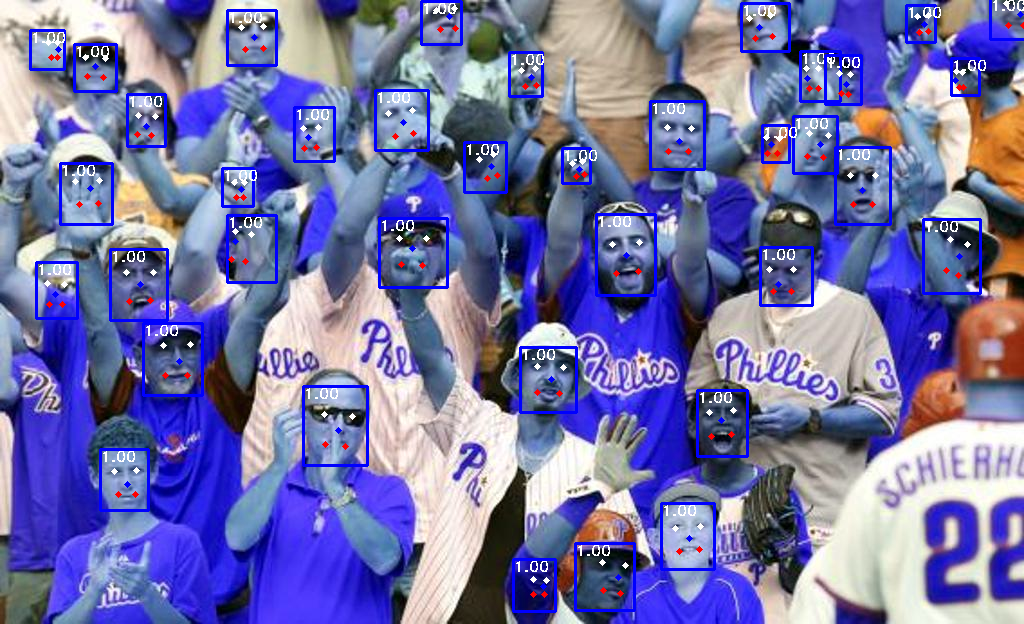

In [3]:
img_uint8 = cv2.imread("./curve/test.jpg", cv2.IMREAD_COLOR)
img_f32 = np.float32(img_uint8)

detector = RetinaFaceDetector()
scores, boxes, landms = detector.inference_one(img_f32)
detector.draw(img_uint8, scores, boxes, landms)

In [4]:
%timeit scores, boxes, landms = detector.inference_one(img_f32)

17.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%load_ext line_profiler

In [6]:
%lprun -f detector.inference_one scores, boxes, landms = detector.inference_one(img_f32)